<a href="https://colab.research.google.com/github/cesarcontre/Neuronal-Network/blob/main/weasfomes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
%cd /content/drive/MyDrive/Colab Notebooks/BitcoinLSTMcustome

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/BitcoinLSTMcustome


In [ ]:
!pip install pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=754dd89da5d42bd1cea126e800a816e4c66a933c0e1fde7be0f418f6b461e668
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [ ]:
import os
import pandas as pd
import numpy as np
import coinapi
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
from featurebigger import add_features

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Conv1D, MaxPooling1D
import tensorflow as tf
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from keras.regularizers import l1
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from datetime import datetime, timedelta
from math import sqrt
import math
import matplotlib.dates as mdates
import random

In [ ]:
#missing_data = coinapi.get_bitcoin_data("2023-08-28T9:51:00", "2023-08-28T10:51:00")

In [ ]:
#data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BitcoinLSTMcustome/08112023_1126.csv')

In [ ]:
#data = pd.concat([data, missing_data], ignore_index=True)

In [ ]:
#data.to_csv('/content/drive/MyDrive/Colab Notebooks/BitcoinLSTMcustome/08142023_0907.csv')

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BitcoinLSTMcustome/08142023_0907.csv')

In [ ]:
df = data

In [ ]:
import numpy as np
import pandas as pd
import pandas.tseries.holiday as hol
import pandas_ta as ta


USFederalHolidayCalendar = hol.USFederalHolidayCalendar



def add_features(df, time='min'):
    if time == 'min':
        factor = 60
    elif time == 'hour':
        factor = 1
    else:
        raise ValueError("Invalid time unit")

    # Simple Moving Average
    window_size = 20
    df['SMA_price_open'] = df['price_open'].rolling(window=window_size).mean()
    df['SMA_price_low'] = df['price_low'].rolling(window=window_size).mean()
    df['SMA_price_high'] = df['price_high'].rolling(window=window_size).mean()
    df['SMA_price_close'] = ta.sma(df['price_close'], length=14)
    df['SMA_volume_traded'] = ta.sma(df['volume_traded'], length=14)

    #RSI
    df['RSI_price_close'] = ta.rsi(df['price_close'], length=14)
    df['RSI_volume_traded'] = ta.rsi(df['volume_traded'], length=14)

    # MACD
    short_window=12
    long_window=26
    signal_window=9
    short_ema = df['price_close'].ewm(span=short_window, adjust=False).mean()
    long_ema = df['price_close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = short_ema - long_ema

    # Stochastic Oscillator
    df['Stochastic_Oscillator'] = 100 * (df['price_close'] - df['price_low'].rolling(window=14).min()) / (df['price_high'].rolling(window=14).max() - df['price_low'].rolling(window=14).min())

    # Momentum
    df['Momentum'] = df['price_close'] - df['price_close'].shift(4)

    # Bollinger Bands
    df['Bollinger_Middle_Band'] = df['price_close'].rolling(window=20).mean()
    df['Bollinger_Upper_Band'] = df['Bollinger_Middle_Band'] + 2*df['price_close'].rolling(window=20).std()
    df['Bollinger_Lower_Band'] = df['Bollinger_Middle_Band'] - 2*df['price_close'].rolling(window=20).std()

    # ATR - Average True Range
    high_low = df['price_high'] - df['price_low']
    high_close = np.abs(df['price_high'] - df['price_close'].shift())
    low_close = np.abs(df['price_low'] - df['price_close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    df['ATR'] = ranges.max(axis=1).rolling(window=14).mean()

    # OBV (On-Balance Volume)
    df['Daily_Return'] = df['price_close'].pct_change()
    df['Direction'] = np.where(df['Daily_Return'] >= 0, 1, -1)
    df['Direction'][0] = 0
    df['OBV'] = (df['volume_traded'] * df['Direction']).cumsum()


    # Lagged Features
    df['Lagged_price_open'] = df['price_open'].shift(periods=1)
    df['Lagged_price_low'] = df['price_low'].shift(periods=1)
    df['Lagged_price_high'] = df['price_high'].shift(periods=1)
    df['Lagged_price_close'] = df['price_close'].shift(1)
    df['Lagged_volume_traded'] = df['volume_traded'].shift(1)

    # Change and Percentage Change
    df['Change_price_close'] = df['price_close'].diff()
    df['Change_volume_traded'] = df['volume_traded'].diff()
    df['Pct_Change_price_close'] = df['price_close'].pct_change()
    df['Pct_Change_volume_traded'] = df['volume_traded'].pct_change()

    # Rolling Metrics
    df['Rolling_Mean_price_close'] = df['price_close'].rolling(window=20).mean()
    df['Rolling_Std_price_close'] = df['price_close'].rolling(window=20).std()

    # Time-Based Features
    df['Minute'] = pd.to_datetime(df['time_period_start']).dt.minute
    df['Hour'] = pd.to_datetime(df['time_period_start']).dt.hour
    df['DayOfWeek'] = pd.to_datetime(df['time_period_start']).dt.dayofweek

    # Holiday and Weekend Indicators
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=pd.to_datetime(df['time_period_start']).min(), end=pd.to_datetime(df['time_period_start']).max())
    df['Holiday'] = pd.to_datetime(df['time_period_start']).isin(holidays)
    df['Weekend'] = df['DayOfWeek'].isin([5, 6])

    df = df.replace([np.inf, -np.inf], np.nan)  # replace infinite values with NaN
    df = df.fillna(df.mean())  # fill NaN values with column mean


    return df

In [ ]:
from joblib import Parallel, delayed

In [ ]:

def process_data_in_parallel(df, batch_size=10000):
    num_batches = len(df) // batch_size + 1

    # Split the dataframe into batches
    batches = [df[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]

    # Use joblib to apply the function in parallel
    processed_batches = Parallel(n_jobs=-1)(delayed(add_features)(batch) for batch in batches)

    # Concatenate the processed batches
    processed_df = pd.concat(processed_batches, axis=0)

    return processed_df


In [ ]:
# Assuming your dataframe is named df
processed_df = process_data_in_parallel(df)


In [ ]:
df = processed_df

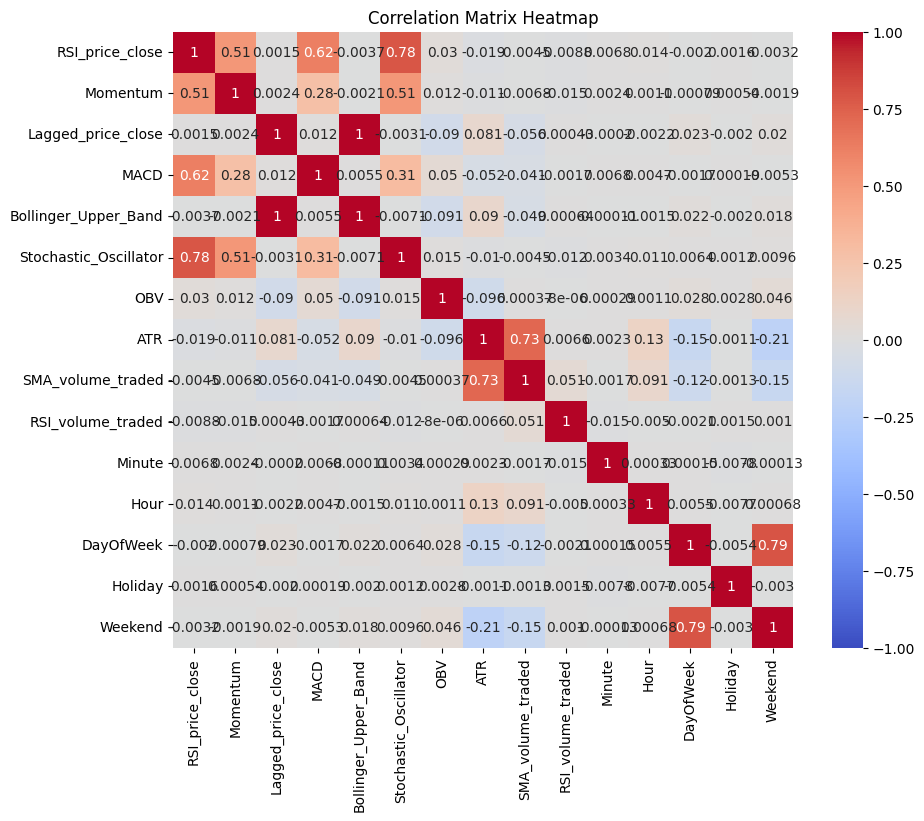

In [ ]:
datAug = df[['RSI_price_close','Momentum','Lagged_price_close','MACD','Bollinger_Upper_Band','Stochastic_Oscillator','OBV','ATR','SMA_volume_traded','RSI_volume_traded','Minute','Hour','DayOfWeek','Holiday','Weekend']]
corr_matrix = datAug.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
features = ['RSI_price_close','Momentum','MACD','Bollinger_Upper_Band','Bollinger_Lower_Band','Stochastic_Oscillator','OBV','ATR','SMA_volume_traded','RSI_volume_traded','Minute','Hour','DayOfWeek','Holiday','Weekend']
X = df[features]

In [ ]:
variables = X.columns
adf_results = []


# Perform ADF test for each variable
for var in variables:
    adf_test = adfuller(X[var])
    adf_results.append([var,adf_test[0],adf_test[1]])
adf_resultsdf = pd.DataFrame(adf_results, columns=['Variable', 'ADF Statistic', 'p-value'])
adf_resultsdf.set_index('Variable',inplace=True)
print(adf_resultsdf)

                       ADF Statistic       p-value
Variable                                          
RSI_price_close           -74.389854  0.000000e+00
Momentum                  -73.038108  0.000000e+00
Lagged_price_close         -1.050712  7.343223e-01
MACD                      -64.070116  0.000000e+00
Bollinger_Upper_Band       -1.072871  7.257687e-01
Bollinger_Lower_Band       -1.052763  7.335374e-01
Stochastic_Oscillator     -82.006185  0.000000e+00
OBV                        -6.956251  9.412503e-10
ATR                       -31.151991  0.000000e+00
SMA_volume_traded         -44.673414  0.000000e+00
RSI_volume_traded         -87.977678  0.000000e+00
Minute                    -72.488182  0.000000e+00
Hour                      -36.884178  0.000000e+00
DayOfWeek                 -12.637730  1.457527e-23
Holiday                  -753.033200  0.000000e+00
Weekend                   -12.145059  1.617871e-22


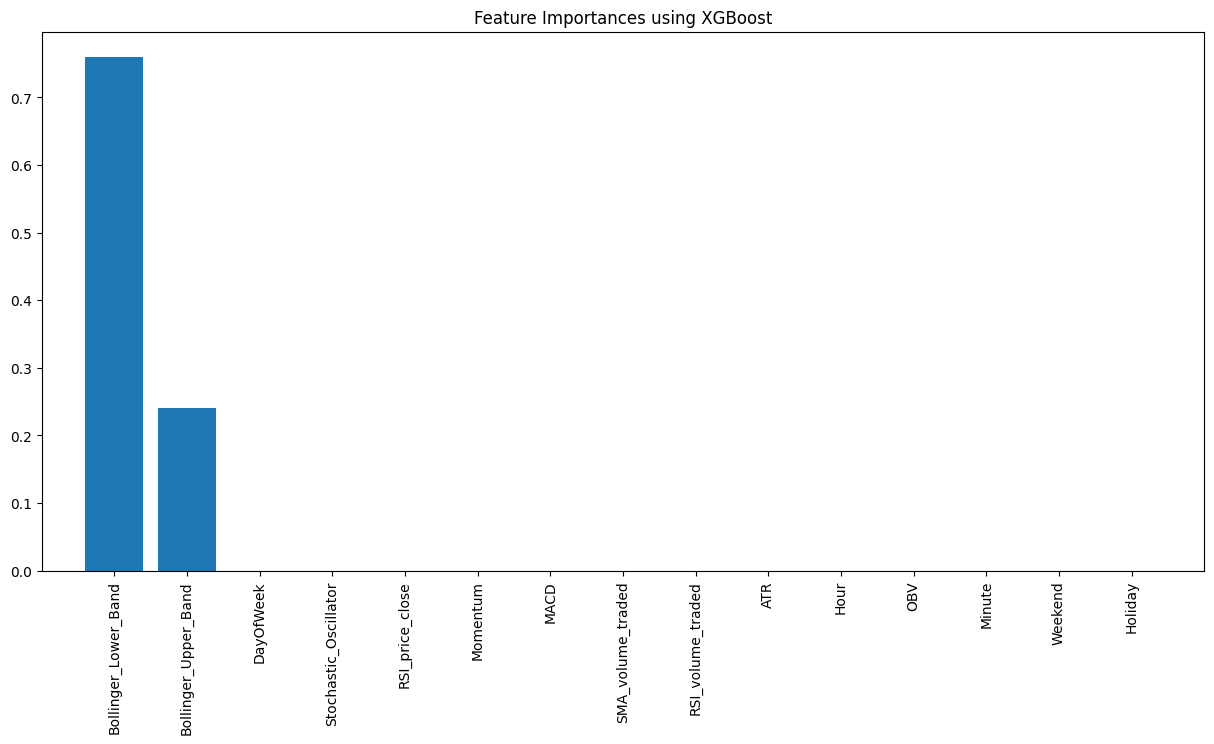

In [ ]:
import xgboost as xgb

# Define features and target
X = df[features]
y = df['price_close']

# Fit the XGBoost model
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X, y)

# Get feature importances
importances = model_xgb.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(15,7))
plt.title("Feature Importances using XGBoost")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
# Select features
#X = df[['SMA_Close','SMA_Volume','RSI_Close','RSI_Volume','Lagged_Close','Lagged_Volume','Change_Close','Change_Volume','Pct_Change_Close','Pct_Change_Volume','Rolling_Mean_Close','Rolling_Std_Close','Hour','DayOfWeek','Holiday','Weekend']].values
#features = ['SMA_price_close','RSI_price_close','Lagged_price_close','Change_price_close','Pct_Change_price_close','Rolling_Mean_price_close','Rolling_Std_price_close','Minute','Hour','DayOfWeek']
features = ['RSI_price_close','Momentum','MACD','Bollinger_Upper_Band','Bollinger_Lower_Band','Stochastic_Oscillator','OBV','ATR','SMA_volume_traded','RSI_volume_traded','Minute','Hour','DayOfWeek','Holiday','Weekend']
#features = ['SMA_price_close','RSI_price_close','Change_price_close','Pct_Change_price_close','Rolling_Mean_price_close','Rolling_Std_price_close','Minute','Hour','DayOfWeek']
X = df[features].values

# Select target variable
y = df['price_close'].values  # or 'Open', 'High', 'Low', depending on what you want to predict

# Normalize the features
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the features and target variable into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# Transform the data into a format suitable for LSTM
n_steps = 60 #equivalent of 60 minutes
look_back = 180  #how many minutes you see in the past
def create_dataset(X, y, look_back=look_back):
    X_arr, y_arr = [], []
    for i in range(len(X) - look_back):
        a = X[i:(i + look_back), :]
        X_arr.append(a)
        y_arr.append(y[i + look_back])
    return np.array(X_arr), np.array(y_arr)



# Split the data into train + validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# Split the train + validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, shuffle=False)  # 0.25 x 0.8 = 0.2 will be the validation set

# Using your create_dataset function to format the data for LSTM
X_train, y_train = create_dataset(X_train, y_train, look_back)
X_val, y_val = create_dataset(X_val, y_val, look_back)
X_test, y_test = create_dataset(X_test, y_test, look_back)



In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers.experimental import Nadam
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, Bidirectional, LSTM,
                                     Attention, Dropout, Dense)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.initializers import HeNormal,GlorotNormal,GlorotUniform
from keras_tuner import HyperModel
import itertools
from keras_tuner import RandomSearch

In [ ]:

# Define model parameters
SEQUENCE_LENGTH = 180  # Adjust based on your sequence length
FEATURES = X_train.shape[2]  # Number of features in your data
def custom_loss(alpha=1.0):
    def loss(y_true, y_pred):
        mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
        penalty = tf.abs(tf.reduce_min(y_true - y_pred)) + tf.abs(tf.reduce_max(y_true - y_pred))
        return mse + alpha * penalty
    return loss
class BitcoinPriceLSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        inputs = Input(shape=self.input_shape)

        # Convolutional layer
        x = Conv1D(
            filters=hp.Int('conv_filters', min_value=20, max_value=120, step=20),
            kernel_size=hp.Choice('conv_kernel_size', values=[2, 3, 4]),
            activation='relu',
            kernel_initializer=GlorotNormal()
        )(inputs)
        x = MaxPooling1D(pool_size=2)(x)

        # Bidirectional LSTM with attention mechanism
        x = Bidirectional(LSTM(
            units=hp.Int('lstm_units_1', min_value=30, max_value=60, step=10),
            return_sequences=True,
            activity_regularizer=l1(0.00001),
            recurrent_regularizer=l2(hp.Choice('lstm_l2_reg_1', values=[0.001, 0.01, 0.1]))
        ))(x)
        x = Dropout(hp.Float('lstm_dropout_1', 0.1, 0.5, step=0.1))(x)
        x = Bidirectional(LSTM(
            units=hp.Int('lstm_units_2', min_value=20, max_value=40, step=10),
            return_sequences=True
        ))(x)
        x = Dropout(hp.Float('lstm_dropout_2', 0.1, 0.5, step=0.1))(x)

        # Attention layer
        attention_output = Attention(use_scale=True)([x, x])
        x = tf.keras.layers.Concatenate(axis=-1)([x, attention_output])

        # Fully connected layers
        x = Dense(
            units=hp.Int('dense_units', min_value=20, max_value=80, step=10),
            activation='relu'
        )(x)
        x = Dropout(hp.Float('dense_dropout', 0.1, 0.5, step=0.1))(x)
        outputs = Dense(1)(x)

        # Compile the model
        optimizer = Nadam(learning_rate=hp.Choice('learning_rate', values=[1e-5, 1e-4, 1e-3]))

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=optimizer,
            loss=custom_loss(alpha=hp.Float('loss_alpha', 0.5, 3.0, step=0.5)),
            metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()]
        )

        return model

In [ ]:
# Initialize the hypermodel
hypermodel = BitcoinPriceLSTMHyperModel(input_shape=(SEQUENCE_LENGTH, FEATURES))

# Set up the random search tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=30,  # Number of hyperparameter combinations to try
    directory='keras_tuner_dir',
    project_name='lstm_tuning'
)

# Define your callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
]

# Start the hyperparameter search
tuner.search(X_train, y_train, validation_data=(X_val, y_val),
             epochs=100, batch_size=32, callbacks=callbacks)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

In [ ]:
# Train the best model further if needed
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/100
10627/10627 [==============================] - 244s 21ms/step - loss: 0.1593 - mean_absolute_error: 0.0292 - mean_absolute_percentage_error: 112.8713 - val_loss: 0.0946 - val_mean_absolute_error: 0.0760 - val_mean_absolute_percentage_error: 9.6211 - lr: 1.0000e-04
Epoch 2/100
10627/10627 [==============================] - 217s 20ms/step - loss: 0.0554 - mean_absolute_error: 0.0136 - mean_absolute_percentage_error: 60.0677 - val_loss: 0.0853 - val_mean_absolute_error: 0.0709 - val_mean_absolute_percentage_error: 8.9633 - lr: 1.0000e-04
Epoch 3/100
10627/10627 [==============================] - 217s 20ms/step - loss: 0.0529 - mean_absolute_error: 0.0133 - mean_absolute_percentage_error: 60.7126 - val_loss: 0.1049 - val_mean_absolute_error: 0.0893 - val_mean_absolute_percentage_error: 11.3120 - lr: 1.0000e-04
Epoch 4/100
10627/10627 [==============================] - 217s 20ms/step - loss: 0.0517 - mean_absolute_error: 0.0128 - mean_absolute_percentage_error: 55.6163 - val_los

MOdel 2

In [ ]:
# 4. Evaluation
loss, mae, mape = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.4f}")

3544/3544 [==============================] - 11s 3ms/step - loss: 0.0842 - mean_absolute_error: 0.2699 - mean_absolute_percentage_error: 31.6214
Test Loss: 0.0842
Test MAE: 0.2699
Test MAPE: 31.6214


  Arima + LSTM

In [ ]:
model_path = "/content/drive/MyDrive/Colab Notebooks/BitcoinLSTMcustome/20mina81percentage.h5"
model.save(model_path)


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Colab Notebooks/BitcoinLSTMcustome/20mina81percentage.h5')

In [ ]:
import tf2onnx

# Convert the model
onnx_model, _ = tf2onnx.convert.from_keras(model)

# Save the ONNX model to disk
with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())


In [ ]:
pip install onnx


In [ ]:
import onnx

# Load the ONNX model
onnx_model = onnx.load("model.onnx")

# Check the model
onnx.checker.check_model(onnx_model)

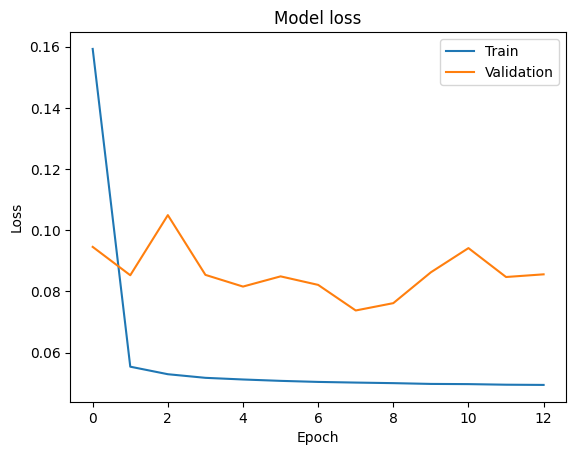

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Generate predictions on the test set
y_pred = best_model.predict(X_test)
# Calculate the R^2 score
y_pred_next_step = y_pred[:, 0, :].squeeze()
r2 = r2_score(y_test, y_pred_next_step )
print('R^2 score:', r2)

3539/3539 [==============================] - 24s 6ms/step
R^2 score: -0.6745400457094661


In [ ]:
def evaluate_model(model, X_test, y_test, target_scaler):
    # Calculate the model's prediction for the test data
    y_pred = model.predict(X_test)

    # Extract the predictions for the next step
    y_pred_next_step = y_pred[:, 0, :].squeeze()

    # Inverse transform the scaled data
    y_test_inv = target_scaler.inverse_transform(y_test)
    y_pred_inv = target_scaler.inverse_transform(y_pred_next_step.reshape(-1, 1))

    # Create binary variables for the direction of the price movement
    y_test_direction = (np.diff(y_test_inv.reshape(-1)) >= 0).astype(int)
    y_pred_direction = (np.diff(y_pred_inv.reshape(-1)) >= 0).astype(int)

    # Calculate the Hit Rate
    hit_rate = accuracy_score(y_test_direction[:-1], y_pred_direction[:-1])  # Adjusted to match length after diff
    print('Hit Rate:', hit_rate)

    # Print the mean squared error loss
    test_loss = model.evaluate(X_test, y_test)
    print('Test Loss:', test_loss)

    # Plot actual vs predicted values for next step
    plt.figure(figsize=(14, 5))
    plt.plot(y_test_inv, color='blue', label='Actual')
    plt.plot(y_pred_inv, color='red', label='Predicted')
    plt.title('Actual vs Predicted Values for the Next Step')
    plt.legend()
    plt.show()

    # Calculate and print R^2 score for next step
    r2 = r2_score(y_test, y_pred_next_step)
    print('R^2 score for the next step predictions:', r2)

3544/3544 [==============================] - 14s 4ms/step
Hit Rate: 0.5040040216605225
3544/3544 [==============================] - 19s 5ms/step - loss: 0.9545 - mean_absolute_error: 0.2190 - mean_absolute_percentage_error: 25.5518
Test Loss: [0.9544909000396729, 0.21899276971817017, 25.551801681518555]


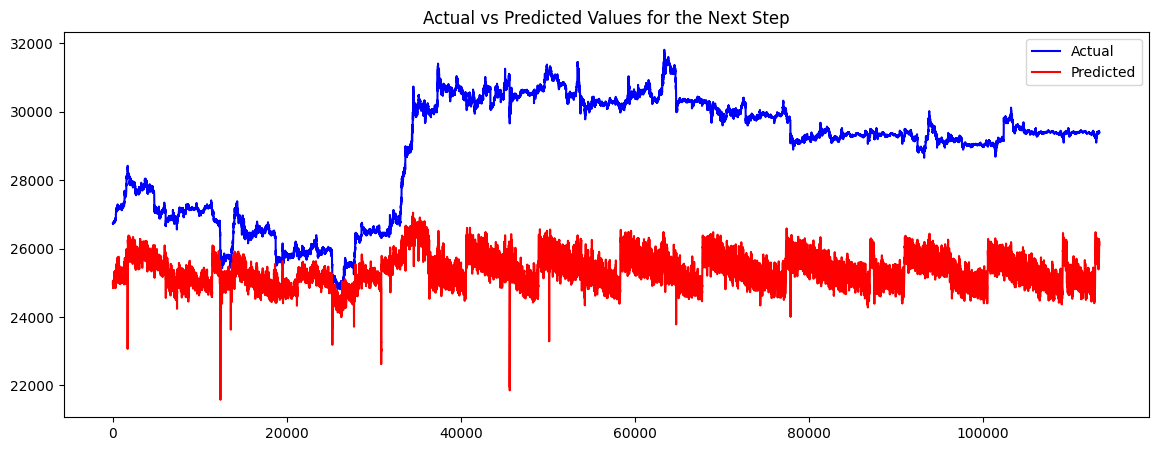

R^2 score for the next step predictions: -4.517927872248954


In [ ]:
evaluate_model(model, X_test, y_test, y_scaler)

In [ ]:
dft = coinapi.get_bitcoin_data("2023-08-23T00:00:00", "2023-08-24T16:55:00")



In [ ]:
dft = add_features(dft,'min')

<ipython-input-7-e9f7cd6b5e17>:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-7-e9f7cd6b5e17>:93: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



In [ ]:
def preprocess_for_future(df, look_back=2):
    # Select features ['SMA_price_close','RSI_price_close','Lagged_price_open','Change_price_close','Pct_Change_price_close','Rolling_Mean_price_close','Rolling_Std_price_close','Minute','Hour','DayOfWeek']
    features =  ['SMA_price_close','RSI_price_close','Momentum','Lagged_price_close','MACD','Bollinger_Middle_Band','Bollinger_Upper_Band','Bollinger_Lower_Band','Stochastic_Oscillator','OBV','ATR','SMA_volume_traded','RSI_volume_traded','Minute','Hour','DayOfWeek','Holiday','Weekend']
    X = df[features].values

    # Select target variable
    y = df['price_close'].values  # or 'Open', 'High', 'Low', depending on what you want to predict

    # Normalize the features
    y_scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Transform the data into a format suitable for LSTM
    X_arr, y_arr = [], []
    for i in range(len(X)-look_back-1):
        a = X[i:(i+look_back), :]
        X_arr.append(a)
        y_arr.append(y_scaled[i + look_back])
    X, y_scaled = np.array(X_arr), np.array(y_arr)

    # Reshape input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], look_back, X.shape[2])) # Change this line to use look_back


    return X, y, y_scaler

In [ ]:
Xi,yi, y_scalarp = preprocess_for_future(dft)

In [ ]:
Xi = Xi.astype('float32')

In [ ]:
predictions = []
features = ['SMA_price_close','RSI_price_close','Momentum','Lagged_price_close','MACD','Bollinger_Middle_Band','Bollinger_Upper_Band','Bollinger_Lower_Band','Stochastic_Oscillator','OBV','ATR','SMA_volume_traded','RSI_volume_traded','Minute','Hour','DayOfWeek','Holiday','Weekend']
for i in range(30): # Predict next 20 minutes
    # Use the latest sequence from Xi
    last_sequence = Xi[-1].reshape(1, Xi.shape[1], Xi.shape[2])
    next_pred = model.predict(last_sequence)

    # Store the prediction
    predictions.append(next_pred[0][0])

    # Shift the last sequence and append the next prediction
    last_sequence = np.roll(last_sequence, shift=-1, axis=1)
    last_sequence[0, -1, -1] = next_pred[0][0]  # Appending to the end of sequence. Modify if you're appending somewhere else.

    # Append to Xi for subsequent iterations
    Xi = np.append(Xi, last_sequence.reshape(1, Xi.shape[1], Xi.shape[2]), axis=0)



ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-c5f29fc6e8a7>", line 6, in <cell line: 3>
    next_pred = model.predict(last_sequence)
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/constant_op.py", line 103, in convert_to_eager_tensor
    return ops.EagerTensor(value, ctx.device_name, dtype)
ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
Attri

In [ ]:
predictions

[array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=float32),
 array([1.5994446], dtype=fl

In [ ]:
predicted_output = predicted_output.reshape(-1, 1)
predicted_value_original_scale = y_scalarp.inverse_transform(predicted_output)


In [ ]:

# Extract the actual values corresponding to the predicted values
# Since we are using a look_back, we need to adjust the indexes
actual_values = yi[-len(predicted_value_original_scale):]

# Plotting
fig = go.Figure()

# Plotting actual values
fig.add_trace(go.Scatter(x=list(range(len(actual_values))),
                         y=actual_values, mode='lines', name='Actual'))

# Plotting predicted values
fig.add_trace(go.Scatter(x=list(range(len(predicted_value_original_scale))),
                         y=predicted_value_original_scale.flatten(), mode='lines', name='Predicted'))

fig.show()

In [ ]:
def make_multi_step_predictions_v2(model, input_data, n_steps, look_back, n_features):
    # Initialize the current input sequence and list to store predictions
    current_input = input_data[-1].reshape(1, look_back, n_features)
    predictions = []

    # Make predictions for the specified number of steps
    for step in range(n_steps):
        # Make a prediction
        prediction = model.predict(current_input)

        # Store the prediction
        predictions.append(prediction[0, 0])  # Adjust this as needed based on the shape of prediction

        # Update the current input sequence
        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, :] = prediction[0, :, 0]  # Adjusting the shape here

    return np.array(predictions)



In [ ]:
print(Xi.shape)

(46, 60, 10)


In [ ]:
make_multi_step_predictions_v2(model, Xi, 60, 60, 10)

1/1 [==============================] - 0s 20ms/step


ValueError: ignored

In [ ]:
predicted_output = model.predict(Xi)


In [ ]:
predicted_output = predicted_output.reshape(-1, 1)
predicted_output_inv = y_scalarp.inverse_transform(predicted_output)

# Extract the actual values corresponding to the predicted values
# Since we are using a look_back, we need to adjust the indexes
actual_values = yi[-len(predicted_output_inv):]

# Plotting
fig = go.Figure()

# Plotting actual values
fig.add_trace(go.Scatter(x=list(range(len(actual_values))),
                         y=actual_values, mode='lines', name='Actual'))

# Plotting predicted values
fig.add_trace(go.Scatter(x=list(range(len(predicted_output_inv))),
                         y=predicted_output_inv.flatten(), mode='lines', name='Predicted'))

fig.show()

In [ ]:
def make_multi_step_predictions(model, input_sequence, n_steps, look_back, n_features):
    # Initialize the current input sequence and list to store predictions
    current_input = input_sequence[-1].reshape(1, look_back, n_features)
    predictions = []

    # Make predictions for the specified number of steps
    for step in range(n_steps):
        # Make a prediction
        prediction = model.predict(current_input)

        # Store the prediction
        predictions.append(prediction[0, 0])  # Adjust this as needed based on the shape of prediction

        # Update the current input sequence
        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, :] = prediction[0, :n_features]  # Assuming prediction has the shape (1, n_features)

    return np.array(predictions)


In [ ]:
print(Xi[-1].shape)

(10, 10)


In [ ]:
raw_predi = make_multi_step_predictions(model, Xi, 60, 60,10)

1/1 [==============================] - 0s 25ms/step


In [ ]:
raw_predi

array([1.2585964 , 1.0241908 , 0.8556845 , 0.8212906 , 0.77804387,
       0.743379  , 0.7084701 , 0.67421794, 0.64255357, 0.622071  ,
       0.61504424, 0.6001723 , 0.60307145, 0.6234988 , 0.6403414 ,
       0.64920783, 0.65188026, 0.6494957 , 0.6460694 , 0.64358413,
       0.64137673, 0.6399065 , 0.63927686, 0.63876927, 0.63879406,
       0.63950074, 0.64044654, 0.6410738 , 0.6413655 , 0.6413275 ],
      dtype=float32)

In [ ]:
raw_predi_2d = raw_predi.reshape(-1, 1)  # Reshape to 2D array
predictions = y_scalerp.inverse_transform(raw_predi_2d)  # Inverse transform the reshaped array


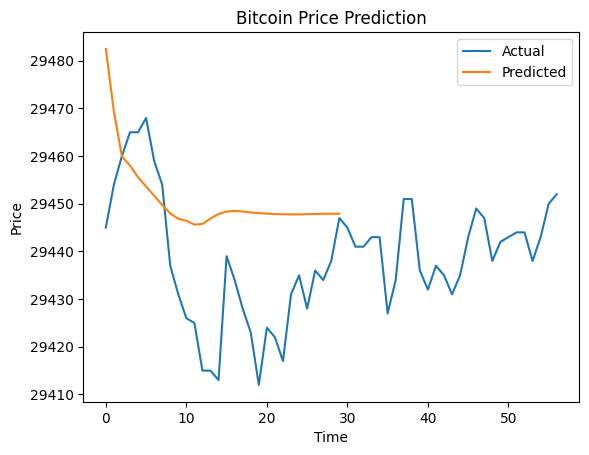

In [ ]:
# Plot the actual values
plt.plot(yi, label='Actual')

# Plot the predicted values
plt.plot(predictions, label='Predicted')

plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.show()